In [1]:
# For matrix calculation
import cv2
import numpy as np
import os

# For visualization
import matplotlib.pylab as plt
%matplotlib inline

# Random number generator
import random

In [2]:
# Load the training_data.npy numpy file
# This file includes our data which we collected before. Every folder has own training_data.npy
# PATH is data folder we want to train
# Only change the PATH
PATH='../deep_learning/data/006/'
data = np.load(PATH+'training_data.npy')

In [3]:
# Checking if we correctly load the file
data[1]

array(['00000.jpg', '0.0', '0.0'], dtype='<U21')

In [4]:
# Another checking
data[20:30]

array([['00019.jpg', '0.0', '0.0'],
       ['00020.jpg', '0.0', '0.0'],
       ['00021.jpg', '0.0', '0.0'],
       ['00022.jpg', '0.0', '0.0'],
       ['00023.jpg', '0.0', '0.0'],
       ['00024.jpg', '0.0', '0.0'],
       ['00025.jpg', '0.0', '0.0'],
       ['00026.jpg', '0.0', '0.0'],
       ['00027.jpg', '0.0', '0.0'],
       ['00028.jpg', '0.0', '0.0']], dtype='<U21')

In [5]:
# Total number of data
len(data)

469

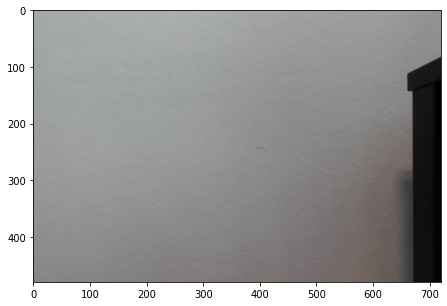

In [6]:
# visualize any image in the data set
# from PIL import Image
# It should be lower than the total number of images which shown in the upper cell
IMAGE = 400
image = cv2.imread(PATH+data[IMAGE][0])
plt.figure(figsize=(15,5))
plt.imshow(image)

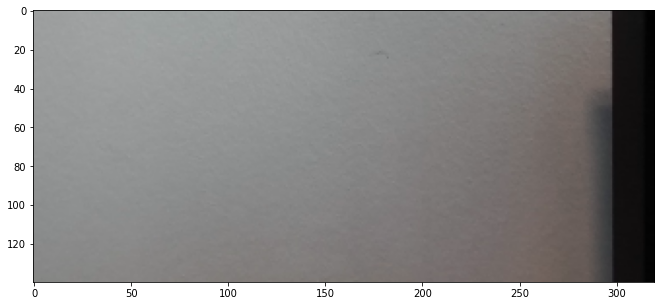

In [7]:
# Cropping the image from the top is useful for training as it will remove irrelevant data
image = cv2.resize(image, (320, 240))
plt.figure(figsize=(15,5))
CROP = 100
plt.imshow(image[CROP:,:,:]) #Cropped image 

In [8]:
# we assign the image paths and the corresponding labels to two separate same size arrays
images = list(img[0] for img in data[1:])
labels = list(float(img[2]) for img in data[1:])

In [9]:
len(images)

468

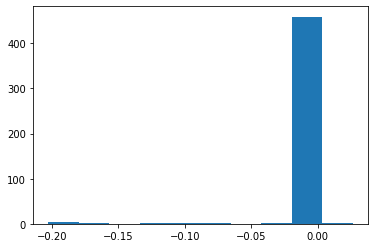

In [10]:
# the distribution of angles in our data
# Uneven distribution of the training leads to failure of training
plt.hist(labels)
plt.show()

# Augmentasyon işlemi

 Augmentasyon işlemini tamamladıktan sonra **model_trainer.py** dosyasında ilgili yere aşağıdaki kod bloğunu yapıştırın.

In [11]:
# In order to correct the angle distribution in the data set, 
# we try to re-add the number of angle records to the list.
# In other words augmentation
nitem = len(images)
for i in range(nitem):
    if labels[i] > 0.05:
        for j in range(7):
            images.append(images[i])
            labels.append(labels[i])    
    if labels[i] < -0.07:
        for j in range(2):
            images.append(images[i])
            labels.append(labels[i]) 

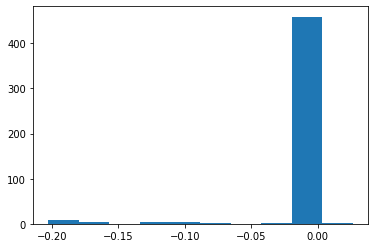

In [12]:
# İlk histgorama göre daga dengeli sayılabilecek bir dağılıma ulaştık
# En doğru çözüm değil ama pratik işe yarar bir alternatif
plt.hist(labels)
plt.show()

In [13]:
len(images), len(labels)

(480, 480)

In [14]:


# Veri setimiz ile ilgili ayarlamalar
# Veri seti küme büyüklüğü batch size
# Verisetinin ne kadarı eğitim ne kadarı test için kullanılacak
# Eğitim %80 , Test %20 
bsize = 8
dlen = len(labels)
splitpoint = int(0.8*dlen)
reindex = list(range(len(labels)))
# Eğtim verisini karıştıryoruz
random.seed(1234)
random.shuffle(reindex)



In [15]:

# Resim üzerinde Rastgele parlaklık değişimi uygulayan bir fonksiyon
# Augmentation function (taken from github)
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV) 
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


# In[ ]:


# ismi verilen resmi okuyup 
# rastgele olarak %50 sine parlaklık değişimi uygulayan fonksiyonu uygulayıp
# resim matrisini dönem bir fonksiyon

def get_matrix(fname):
    img = cv2.imread(PATH+fname)
    img = cv2.resize(img, (320,180))
    if random.randint(0,1) == 1 :
        img = augment_brightness(img)        
    return img[100:,:,:] # Return the cropped image, (320,80)



In [16]:
# Bütün veriyi hafızaya almamız mümkün değil
# Ek olarak bazen çeşitli değişimler - Augmentation - uygulamakda istiyebiliriz
# python generator ile gerektiğinde veri okunur düzenlenir ve eğitim veya test için 
# sisteme verilir
# alttaki fonksiyonlar bu işi yapar

# Generate data for training
def generate_data():
    i = 0
    while True:
        x = []
        y = []
        for j in range(i,i+bsize):  
            ix = reindex[j]
            img = get_matrix(images[ix])
            lbl = np.array([labels[ix]])
            flip = random.randint(0,1)
            if flip == 1:
                img = cv2.flip(img,1)
                lbl = lbl*-1.0
            x.append(img)
            y.append(lbl)
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > splitpoint:
            i = 0
            
# Generate data for validation                  
def generate_data_val():
    i = splitpoint
    while True:
        x = []
        y = []
        for j in range(i,i+bsize): 
            ix = reindex[j]
            x.append(get_matrix(images[ix]))
            y.append(np.array([labels[ix]]))
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > dlen:
            i = splitpoint

In [17]:
try:
    import tensorflow as tf
    print('OK', tf.__version__)
except:
    print('Tensorflow is not installed!')

OK 2.1.0


In [28]:
# Keras için gerekenler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Cropping2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [29]:

# Model based on NVIDIA's End to End Learning for Self-Driving Cars model
# Sıralı bir keras modeli tanılıyoruz
model = Sequential()
# Normalization
# 0 - 255 arası değerler -1 ila 1 arasına çekiliyor
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(80, 320, 3)))
# Evrişim katmanı (5, 5) lik 24 tane 2 şer piksel kayarak
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
# Ağın çıkışı burda vectöre çevriliyor
model.add(Flatten())
# Yapay Sinir ağı kısmı
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
# Ağın çıkışı Açı 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [30]:
# Tanımladığımız ağın yapsı
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 33, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 6336)              0

In [31]:
# Açı değerlerinide -0.3 ila 0.3 aralığından -1 ila 1 aralığına çekebilmek için 3 ile çarpıyoruz
labels = 3*np.array(labels)

In [32]:
weights_path = os.environ['HOME'] + '/marc_models/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)

In [33]:
# Eğitim esnasında test hata değeri en düşük değeri kaydeden bir fonksiyon
model_checkpoint = ModelCheckpoint(weights_path + 'model_new.h5', monitor='val_loss', save_best_only=True)

In [34]:
# Eğitim fonksiyonu 
hs = model.fit_generator(generate_data(),steps_per_epoch=int(splitpoint/ bsize),
                    validation_data=generate_data_val(), 
                    validation_steps=(dlen-splitpoint)/bsize, epochs=10,callbacks=[model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 48 steps, validate for 12.0 steps
Epoch 1/10
48/48 [==============================] - 20s 408ms/step - loss: 0.1686 - val_loss: 0.0105
Epoch 2/10
48/48 [==============================] - 4s 93ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 3/10
48/48 [==============================] - 4s 83ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 4/10
48/48 [==============================] - 4s 83ms/step - loss: 0.0097 - val_loss: 0.0120
Epoch 5/10
48/48 [==============================] - 4s 90ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 6/10
48/48 [==============================] - 4s 83ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 7/10
48/48 [==============================] - 4s 88ms/step - loss: 0.0100 - val_loss: 0.0148
Epoch 8/10
48/48 [==============================] - 5s 110ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 9/10
48/48 [=================

In [35]:
# Eğittiğimiz modeli kaydediyoruz
# Ağ yapsını json olarak
# Ağ parametre değerlerini h5 uzantılı olarak
import json 
# Save model weights and json.
mname = 'model_new'
model.save_weights(weights_path + mname+'.h5')
model_json  = model.to_json()
with open(weights_path + mname +'.json', 'w') as outfile:
    json.dump(model_json, outfile)